In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
pd.set_option("display.max_columns", 85)

In [8]:
from sklearn.decomposition import PCA


def fetch_data(drop_some=True):
    df = pd.read_csv("../data/abnormal_writeout.data.csv")
    if drop_some:
        # trascurare da ACC a UVM
        start_drop = df.columns.get_loc("ACC")
        end_drop = df.columns.get_loc("UVM")
        cols = np.arange(start_drop, end_drop + 1)
        df.drop(df.columns[cols], axis=1, inplace=True)
        # trascurare old_phylo_factor e la prima colonna
        # df.drop("TTT_freq", axis=1, inplace=True)
        df.drop("oldest_phylostratum_factor", axis=1, inplace=True)
        df.drop("Unnamed: 0", axis=1, inplace=True)

        # Drop NaNs
        df.dropna(inplace=True)
    return df


def separate_data(df):
    resp = df["response"].to_numpy()
    occ = df["occ_total_sum"]
    age = df["oldest_phylostratum"].to_numpy()
    conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1).to_numpy()
    return occ, age, conf, resp


def get_PCA(X, expl_var=0.95, plot=False):
    # Fit a PCA
    pca_test = PCA()
    pca_test.fit(X)
    cumsum = np.cumsum(pca_test.explained_variance_ratio_)
    d = np.argmax(cumsum >= expl_var) + 1
    # Apply PCA with d components
    pca_apply = PCA(n_components=d)
    X_PCA = pca_apply.fit_transform(X)
    print("Using {} principal components.".format(d))
    print(f"Reduced features by {(784-d)/784*100:.2f}%.")
    if plot == True:
        sns.heatmap(pd.DataFrame(X_PCA).corr())
        plt.show()
    return X_PCA

# RF su PCs con griglia di parametri. 

Da valutare per ogni elemento della griglia: AUC, AUPRC, precision, recall, F1

## Data

* Incoming datafile has been previously standardized.
* Columns from "ACC" to "UVM" are subsequently dropped.
* Column "oldest_phylostratum_factor" is dropped.
* PCA is applied to the confounding variables (all except occ_total_sum and olders_phylostratum) and PCs are kept only up to 95% explained variance.
* An 80:20 train-test split is applied. 

In [9]:
from sklearn.model_selection import train_test_split

df = fetch_data()
X_ots, X_age, X_conf, Y = separate_data(df)
X_conf_pca = get_PCA(X_conf)

# All features, confounders with PCA
X = np.c_[X_ots, X_age, X_conf_pca]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Feature matrix shape:", X_train.shape, X_test.shape)
print("Label matrix shape:", y_train.shape, y_test.shape)

Using 47 principal components.
Reduced features by 94.01%.
Feature matrix shape: (14536, 49) (3634, 49)
Label matrix shape: (14536,) (3634,)


## Scoring Metrics

https://stackoverflow.com/questions/42562146/classification-report-with-nested-cross-validation-in-sklearn-average-individua

In [10]:
from sklearn.metrics import auc, make_scorer, precision_recall_curve


# area under the precision curve + area under the recall curve
def auprc(y_true, y_scores, **kwargs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    # result is sum of the areas under each curve
    return auc(thresholds, precisions[:-1]) + auc(thresholds, recalls[:-1])


# Create my custom scorer using a wrapper object
auprc_score = make_scorer(auprc, needs_proba=True,)

## Grid-Search Cross-Validation with ROC-AUC

This cell executes a hyperparameter search of every possible combination of the provided options. Each option is 3-fold cross-validated. 

The following parameters and rangers were chosen after our Jan 26 meeting:
> min_samples_leaf: 1, 2, 5, 10, 20,  
> min_samples_split: 2, 5, 10, 20,

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define metrics to be calculated during the grid search, along with their names
my_metrics = {
    "ROC_AUC": "roc_auc",
    "Precision": "precision",
    "Recall": "recall",
    "f1-score": "f1",
    "AUPRC": make_scorer(auprc, needs_proba=True,),  # custom: area under precision-recall-curve
}


# Define the parameter grid
param_grid = {
    # "bootstrap": [True, False],
    # 'max_depth': [10, 20, 30],
    # 'max_features': [2, 3],
    "min_samples_leaf": [1, 2, 5, 10, 20,],
    "min_samples_split": [2, 5, 10, 20],
    # "n_estimators": [100],
}

# Define the grid search object
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    scoring=my_metrics,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    error_score="raise",
    refit="ROC_AUC",  # Final fit
)

# Search
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, error_score='raise', estimator=RandomForestClassifier(),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             refit='ROC_AUC',
             scoring={'AUPRC': make_scorer(auprc, needs_proba=True),
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall', 'f1-score': 'f1'},
             verbose=1)

### Results

The results are easier to read if they are imported into a dataframe.

In [18]:
results = pd.DataFrame(grid_search.cv_results_)
results.drop(list(results.filter(regex="split0")), axis=1, inplace=True)  # Drop some superfluous columns
results.drop(list(results.filter(regex="split1")), axis=1, inplace=True)
results.drop(list(results.filter(regex="split2")), axis=1, inplace=True)
results.drop(list(results.filter(regex="time")), axis=1, inplace=True)
results.drop(["params"], axis=1, inplace=True)

results.to_csv("./data/unbal_gs_results_df", index=None)
results.head()

,param_min_samples_leaf,param_min_samples_split,mean_test_ROC_AUC,std_test_ROC_AUC,rank_test_ROC_AUC,mean_test_Precision,std_test_Precision,rank_test_Precision,mean_test_Recall,std_test_Recall,rank_test_Recall,mean_test_f1-score,std_test_f1-score,rank_test_f1-score,mean_test_AUPRC,std_test_AUPRC,rank_test_AUPRC
0,1,2,0.634457,0.003035,19,0.587815,0.047880,17,0.033728,0.004466,2,0.063688,0.007904,2,0.521045,0.014431,3
1,1,5,0.634389,0.002898,20,0.577131,0.099315,20,0.032817,0.004881,3,0.062090,0.009273,4,0.469180,0.016537,10
2,1,10,0.637465,0.004871,18,0.595893,0.066971,16,0.032817,0.003938,3,0.062141,0.007110,3,0.543843,0.051856,1
3,1,20,0.640550,0.002622,17,0.603825,0.084630,12,0.030994,0.000000,6,0.058911,0.000375,6,0.470892,0.022755,9
4,2,2,0.642879,0.000798,16,0.621495,0.058285,5,0.036463,0.003938,1,0.068875,0.007347,1,0.526820,0.041417,2


In [14]:
for scorer in my_metrics:
    idx = results["rank_test_%s" % scorer].idxmin()
    mean_val = results["mean_test_%s" % scorer][idx]
    std_val = results["std_test_%s" % scorer][idx]
    param_leaf = results.param_min_samples_leaf[idx]
    param_split = results.param_min_samples_split[idx]
    print(
        f"Best {scorer}:\n {mean_val:.4f} +/_ {std_val:.4f} \n min_samples_leaf: {param_leaf}, \n min_samples_split: {param_split}\n"
    )

Best ROC_AUC:
 0.6687 +/_ 0.0041 
 min_samples_leaf: 20, 
 min_samples_split: 20

Best Precision:
 0.6628 +/_ 0.0624 
 min_samples_leaf: 10, 
 min_samples_split: 5

Best Recall:
 0.0365 +/_ 0.0039 
 min_samples_leaf: 2, 
 min_samples_split: 2

Best f1-score:
 0.0689 +/_ 0.0073 
 min_samples_leaf: 2, 
 min_samples_split: 2

Best AUPRC:
 0.5438 +/_ 0.0519 
 min_samples_leaf: 1, 
 min_samples_split: 10



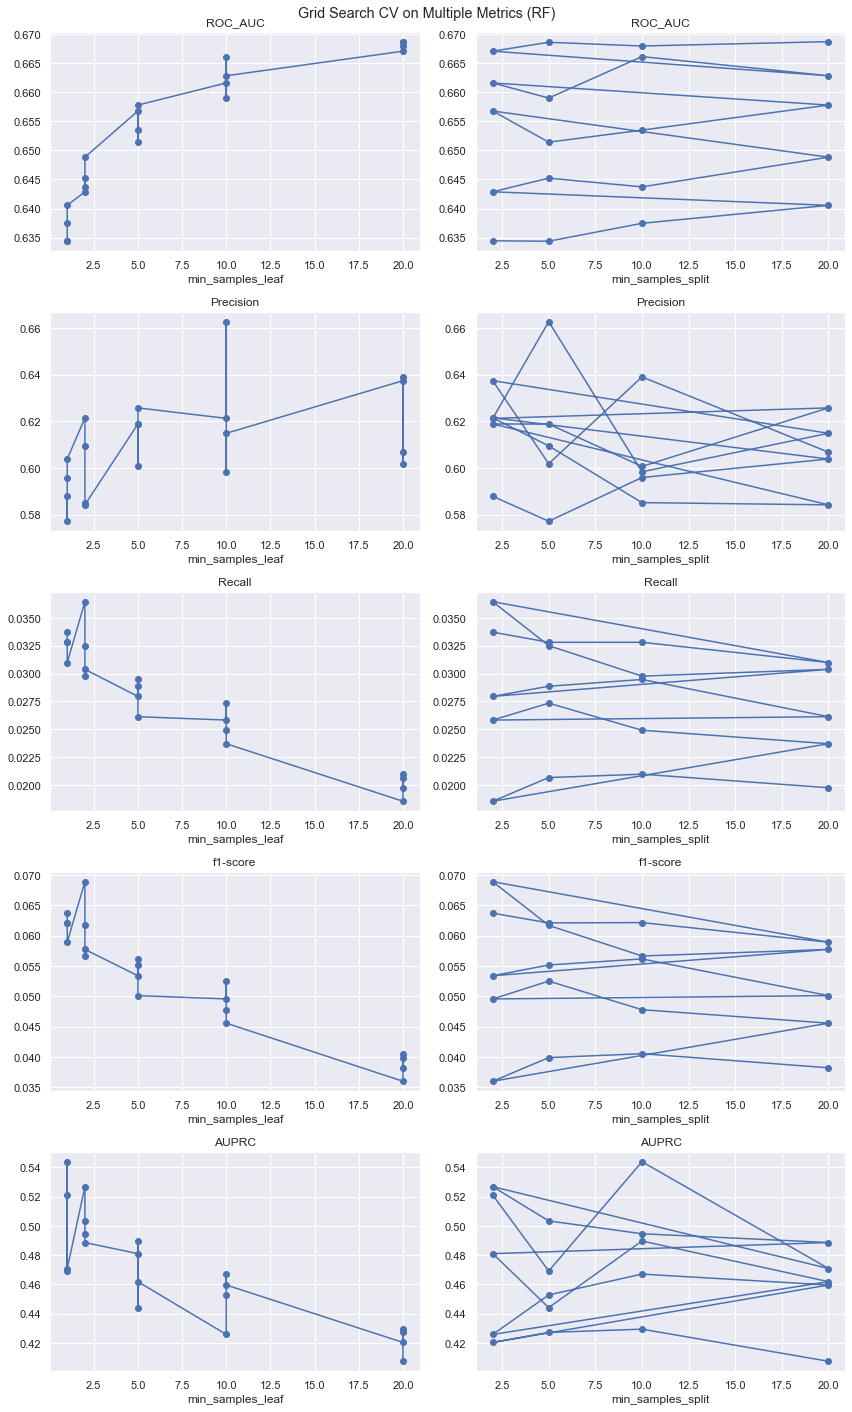

In [15]:
params = ["min_samples_leaf", "min_samples_split"]

fig, ax = plt.subplots(5, 2, figsize=(12, 20))
plt.suptitle("Grid Search CV on Multiple Metrics (RF)")

for ix, score in enumerate((my_metrics)):
    param = params[0]
    x = results["param_%s" % param].to_numpy()
    y = results["mean_test_%s" % score].to_numpy()
    ax[ix, 0].plot(x, y, marker='o')
    ax[ix, 0].title.set_text(score)
    ax[ix, 0].set_xlabel(param)

    param = params[1]
    x = results["param_%s" % param].to_numpy()
    y = results["mean_test_%s" % score].to_numpy()
    ax[ix, 1].plot(x, y, marker='o')
    ax[ix, 1].title.set_text(score)
    ax[ix, 1].set_xlabel(param)

plt.tight_layout()
plt.show()

## Grid Search on balanced RF

Repeat the exact same experiment, but with a balanced RF from imblearn.

In [16]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Define metrics to be calculated during the grid search, along with their names
my_metrics = {
    "ROC_AUC": "roc_auc",
    "Precision": "precision",
    "Recall": "recall",
    "f1-score": "f1",
    "AUPRC": make_scorer(auprc, needs_proba=True,),  # custom: area under precision-recall-curve
}


# Define the parameter grid
param_grid = {
    # "bootstrap": [True, False],
    # 'max_depth': [10, 20, 30],
    # 'max_features': [2, 3],
    "min_samples_leaf": [1, 2, 5, 10, 20,],
    "min_samples_split": [2, 5, 10, 20],
    # "n_estimators": [100],
}

# Define the grid search object
bal_grid_search = GridSearchCV(
    estimator=BalancedRandomForestClassifier(),
    scoring=my_metrics,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    error_score="raise",
    refit="ROC_AUC",  # Final fit
)

# Search
bal_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=BalancedRandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             refit='ROC_AUC',
             scoring={'AUPRC': make_scorer(auprc, needs_proba=True),
                      'Precision': 'precision', 'ROC_AUC': 'roc_auc',
                      'Recall': 'recall', 'f1-score': 'f1'},
             verbose=1)

### Results

In [17]:
results = pd.DataFrame(bal_grid_search.cv_results_)
results.drop(list(results.filter(regex="split0")), axis=1, inplace=True)  # Drop some superfluous columns
results.drop(list(results.filter(regex="split1")), axis=1, inplace=True)
results.drop(list(results.filter(regex="split2")), axis=1, inplace=True)
results.drop(list(results.filter(regex="time")), axis=1, inplace=True)
results.drop(["params"], axis=1, inplace=True)
results.to_csv("./data/bal_gs_results_df", index=None)
results.head()

,param_min_samples_leaf,param_min_samples_split,mean_test_ROC_AUC,std_test_ROC_AUC,rank_test_ROC_AUC,mean_test_Precision,std_test_Precision,rank_test_Precision,mean_test_Recall,std_test_Recall,rank_test_Recall,mean_test_f1-score,std_test_f1-score,rank_test_f1-score,mean_test_AUPRC,std_test_AUPRC,rank_test_AUPRC
0,1,2,0.651449,0.004063,20,0.315809,0.003834,20,0.566393,0.017587,20,0.405478,0.007613,20,0.583518,0.013818,5
1,1,5,0.658519,0.002535,18,0.321569,0.003440,9,0.599514,0.011776,15,0.418535,0.002651,13,0.589965,0.023787,1
2,1,10,0.658502,0.000489,19,0.321868,0.002112,8,0.596475,0.004956,16,0.418105,0.002296,15,0.589841,0.052952,2
3,1,20,0.661758,0.003870,15,0.322433,0.005765,5,0.579155,0.011271,19,0.414184,0.005831,18,0.571157,0.023254,6
4,2,2,0.661707,0.003597,16,0.322928,0.001911,4,0.601033,0.009425,14,0.420113,0.003658,9,0.585894,0.012385,4


In [254]:
for scorer in my_metrics:
    idx = results["rank_test_%s" % scorer].idxmin()
    mean_val = results["mean_test_%s" % scorer][idx]
    std_val = results["std_test_%s" % scorer][idx]
    param_leaf = results.param_min_samples_leaf[idx]
    param_split = results.param_min_samples_split[idx]
    print(
        f"Best {scorer}:\n {mean_val:.4f} +/_ {std_val:.4f} \n min_samples_leaf: {param_leaf}, \n min_samples_split: {param_split}\n"
    )

Best ROC_AUC:
 0.6680 +/_ 0.0066 
 min_samples_leaf: 10, 
 min_samples_split: 10

Best Precision:
 0.3285 +/_ 0.0032 
 min_samples_leaf: 1, 
 min_samples_split: 2

Best Recall:
 0.6177 +/_ 0.0098 
 min_samples_leaf: 10, 
 min_samples_split: 2

Best f1-score:
 0.4241 +/_ 0.0045 
 min_samples_leaf: 10, 
 min_samples_split: 5

Best AUPRC:
 0.5995 +/_ 0.0319 
 min_samples_leaf: 2, 
 min_samples_split: 2



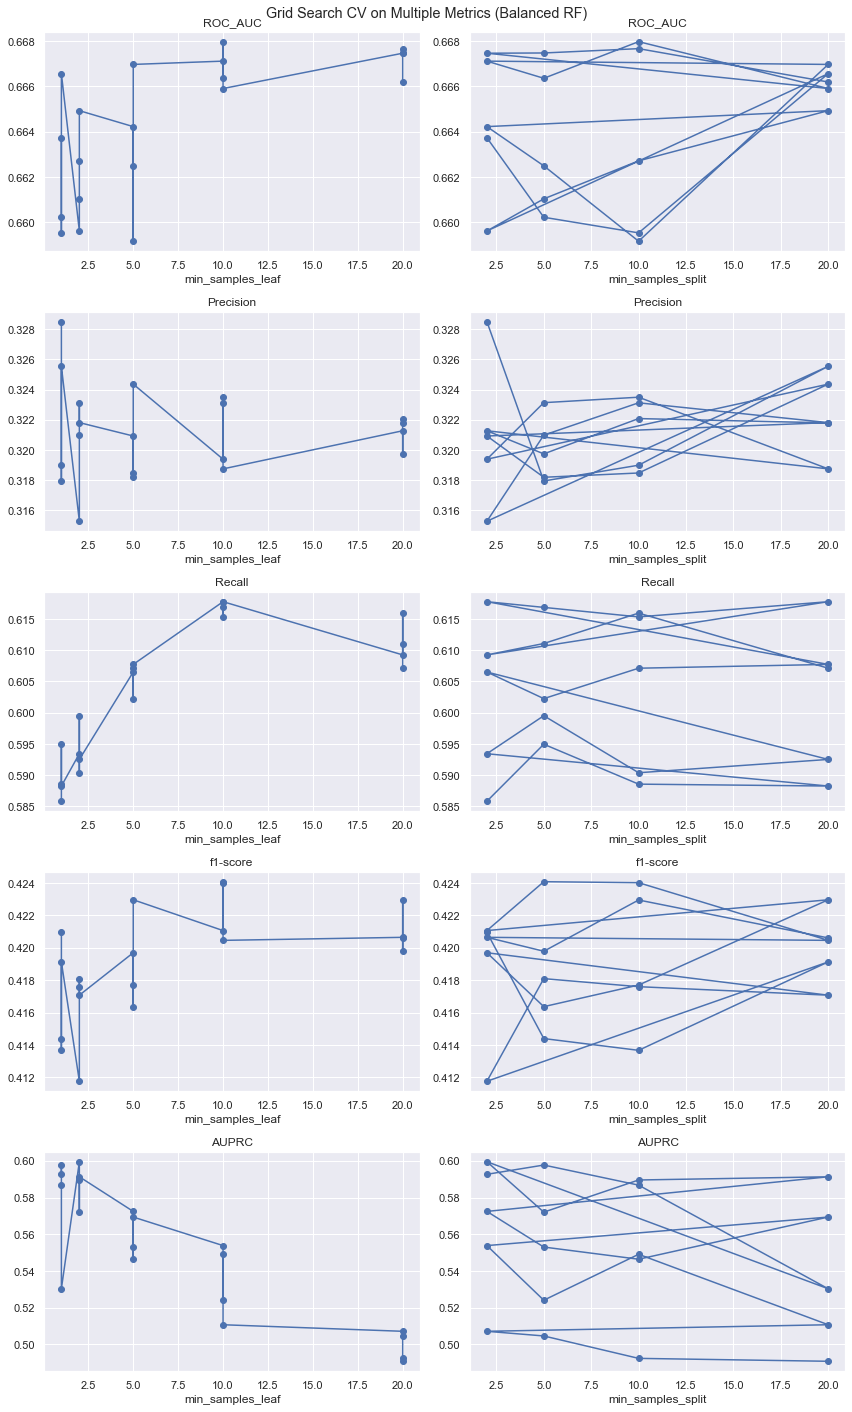

In [262]:
params = ["min_samples_leaf", "min_samples_split"]

fig, ax = plt.subplots(5, 2, figsize=(12, 20))
plt.suptitle("Grid Search CV on Multiple Metrics (Balanced RF)")

for ix, score in enumerate((my_metrics)):
    param = params[0]
    x = results["param_%s" % param].to_numpy()
    y = results["mean_test_%s" % score].to_numpy()
    ax[ix, 0].plot(x, y, marker='o')
    ax[ix, 0].title.set_text(score)
    ax[ix, 0].set_xlabel(param)

    param = params[1]
    x = results["param_%s" % param].to_numpy()
    y = results["mean_test_%s" % score].to_numpy()
    ax[ix, 1].plot(x, y, marker='o')
    ax[ix, 1].title.set_text(score)
    ax[ix, 1].set_xlabel(param)

plt.tight_layout()
plt.show()